In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from scipy.spatial import ConvexHull
from scipy.stats import pearsonr

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle, Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, DivergingNorm, to_rgba

# Atoms
from ase.io import read, write
from ase.visualize.plot import plot_atoms
import chemiscope

# ML
from sklearn.metrics import pairwise_distances

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy
from tools import load_json, recursive_array_convert

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

# Load Data

In [2]:
cutoff = 6.0
spectrum = 'power'
spectrum_name = spectrum.capitalize()
group_name = 'OO+OSi+SiSi'
mixing_suffixes = ['', '_0.0', '_1.0']

In [3]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'
gch_dir = f'{model_dir}/{cutoff}/GCH/4-Class/{spectrum_name}/{group_name}'
# gch_dir = f'{model_dir}/{cutoff}/GCHTMP/4-Class/{spectrum_name}/{group_name}'

In [4]:
# Atomic structures
frames = read(f'{gch_dir}/iza+deem.xyz', index=':')

## Test and train sets

In [5]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
iza_sort_test_idxs = np.argsort(iza_test_idxs)
iza_unsort_test_idxs = np.argsort(iza_sort_test_idxs)

In [6]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)[iza_test_idxs]
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype=str)[iza_test_idxs]
n_iza = len(iza_codes)

deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)[deem_test_idxs]
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)[deem_test_idxs]
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = deem_codes[deem_test_idxs]
n_deem = len(deem_codes)

codes = np.concatenate((iza_codes, deem_codes))
cantons_2 = np.concatenate((np.ones(n_iza, dtype=int), deem_cantons_2))
cantons_4 = np.concatenate((iza_cantons, deem_cantons_4))

## Properties

In [7]:
# Si fractions
Si_fraction_iza = np.loadtxt('../../Raw_Data/IZA_230/compositions.dat', usecols=1)[iza_test_idxs]
Si_fraction_deem = np.ones(n_deem) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

In [8]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_energies.dat')[deem_test_idxs]
iza_energies = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_energies.dat')[iza_test_idxs]
energies = np.concatenate((iza_energies, deem_330k_energies))

# Energies used in the hull construction
gch_energies = np.loadtxt(f'{gch_dir}/energies_per_si.dat')

In [9]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')[deem_test_idxs]
iza_volumes = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_volumes.dat')[iza_test_idxs]
volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [10]:
# Decision functions
deem_330k_dfs_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]
deem_330k_dfs_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]

iza_dfs_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]
iza_dfs_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]

dfs_2 = np.concatenate((iza_dfs_2, deem_330k_dfs_2))
dfs_4 = np.concatenate((iza_dfs_4, deem_330k_dfs_4))

In [11]:
dfs = dfs_2

In [12]:
# 4-Class cantons
predicted_deem_cantons_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_test_idxs]
predicted_deem_cantons_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_test_idxs]

predicted_iza_cantons_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_test_idxs]
predicted_iza_cantons_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_test_idxs]

predicted_cantons_2 = np.concatenate((predicted_iza_cantons_2, predicted_deem_cantons_2))
predicted_cantons_4 = np.concatenate((predicted_iza_cantons_4, predicted_deem_cantons_4))

In [13]:
np.all(np.argmax(deem_330k_dfs_4, axis=1)+1 == predicted_deem_cantons_4)

True

# Convex hull analysis

In [14]:
mixing = ''
T = np.loadtxt(f'{gch_dir}/T{mixing}.dat')
ndim = 3

## GCH

## Standard Hull

In [15]:
gch_vertices = np.loadtxt(f'{gch_dir}/hull_vertices{mixing}.dat', dtype=int)
iza_vertices = gch_vertices[gch_vertices < n_iza]
deem_vertices = gch_vertices[gch_vertices >= n_iza]

vertex_indicators = np.zeros(T.shape[0], dtype=int)
vertex_indicators[gch_vertices] = 1

d = np.loadtxt(f'{gch_dir}/hull_distances{mixing}.dat')
de = np.loadtxt(f'{gch_dir}/hull_distances_energy{mixing}.dat')

## Plot convex hull

In [16]:
def histogram(X, Y, bins, return_edges=False):
    Z, X_edges, Y_edges = np.histogram2d(X, Y, bins=bins, density=True)
    dX = np.diff(X_edges)
    dY = np.diff(Y_edges)
    X_centers = X_edges[0:-1]
    Y_centers = Y_edges[0:-1]
    X_centers += dX / 2
    Y_centers += dY / 2
    X, Y = np.meshgrid(X_centers, Y_centers)
    
    if return_edges:
        return X, Y, Z.T, X_edges, Y_edges
    else:
        return X, Y, Z.T
    
def logbase(x, base):
    return np.log10(x) / np.log10(base)
    
def scale_points(data, min_value, max_value, inverted=False, log=False, base=10, min_limit=None, max_limit=None):
    data = data.copy()
    if min_limit is not None:
        data[data < min_limit] = min_limit
    if max_limit is not None:
        data[data > max_limit] = max_limit
    
    normalized_data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    if inverted:
        normalized_data = 1.0 - normalized_data
    
    if log:
        scaled_data = base ** (
            normalized_data * (
                logbase(max_value, base) - logbase(min_value, base)
            ) + logbase(min_value, base)
        )
    else:
        scaled_data =  normalized_data * (max_value - min_value) + min_value

    return scaled_data

In [17]:
frames_deem_vertices = [frames[idx] for idx in deem_vertices]
frames_iza_vertices = [frames[idx] for idx in iza_vertices]

In [18]:
deem_select = [8326505, 8054476, 8124791, 8321687, 8328575]
iza_select = ['MTN', 'SBN']

deem_select_idxs = [np.nonzero(codes == str(code))[0][0] for code in deem_select]
iza_select_idxs = [np.nonzero(codes == code)[0][0] for code in iza_select]

frames_deem_select = [frames[idx] for idx in deem_select_idxs]
frames_iza_select = [frames[idx] for idx in iza_select_idxs]

In [19]:
vertex_structure_dir = f'{gch_dir}/Vertex_Structures'
os.makedirs(vertex_structure_dir, exist_ok=True)

# cell_size = 50
# for frame in frames_deem_vertices:
#     min_cell_length = np.amin(frame.cell.lengths())
#     n_repeats = np.ceil(cell_size / min_cell_length).astype(int).tolist()
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}"
#         f"_{n_repeats}x{n_repeats}x{n_repeats}.pdb",
#         frame.repeat(n_repeats),
#         format='proteindatabank'
#     )
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}.cif",
#         frame,
#         format='cif'
#     )
    
# for frame in frames_iza_vertices:
#     min_cell_length = np.amin(frame.cell.lengths())
#     n_repeats = np.ceil(cell_size / min_cell_length).astype(int).tolist()
#     write(
#         f"{vertex_structure_dir}/{frame.info['code']}"
#         f"_{n_repeats}x{n_repeats}x{n_repeats}.pdb",
#         frame.repeat(n_repeats),
#         format='proteindatabank'
#     )
#     write(
#         f"{vertex_structure_dir}/{os.path.splitext(frame.info['code'])[0]}.cif",
#         frame,
#         format='cif'
#     )

for frame in frames_deem_select:
    write(
        f"{vertex_structure_dir}/{os.path.splitext(frame.info['Filename'])[0]}.cif",
        frame,
        format='cif'
    )
        
for frame in frames_iza_select:
    write(
        f"{vertex_structure_dir}/{os.path.splitext(frame.info['code'])[0]}.cif",
        frame,
        format='cif'
    )

In [20]:
base = 10
size_min = 1
size_max = 50
alpha_min = 0.01
alpha_max = 1.0
tol = None
sizes = scale_points(de, size_min, size_max, inverted=True, log=True, base=base, min_limit=tol)
alphas = scale_points(de, alpha_min, alpha_max, inverted=True, log=True, base=base, min_limit=tol)

df_limits = np.abs([np.amin(dfs), np.amax(dfs)])
df_idx = np.argmin(df_limits)
df_limit = df_limits[df_idx]
if df_idx == 0:
    extend_key = 'max'
else:
    extend_key = 'min'
extend_key = 'neither'

# vmin = -df_limit
vmin = np.amin(dfs)
# vmax = df_limit
vmax = np.amax(dfs)

norm = DivergingNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
color_map = ScalarMappable(norm=norm, cmap='RdBu')
colors = color_map.to_rgba(dfs, alpha=1.0)
colors[:, -1] = alphas

norm_composition = Normalize(vmin=0.0, vmax=0.33)
color_map_composition = ScalarMappable(norm=norm_composition, cmap='inferno')

ecolors = np.tile(to_rgba(color_list[0]), (len(colors), 1))
ecolors[:, -1] = alphas

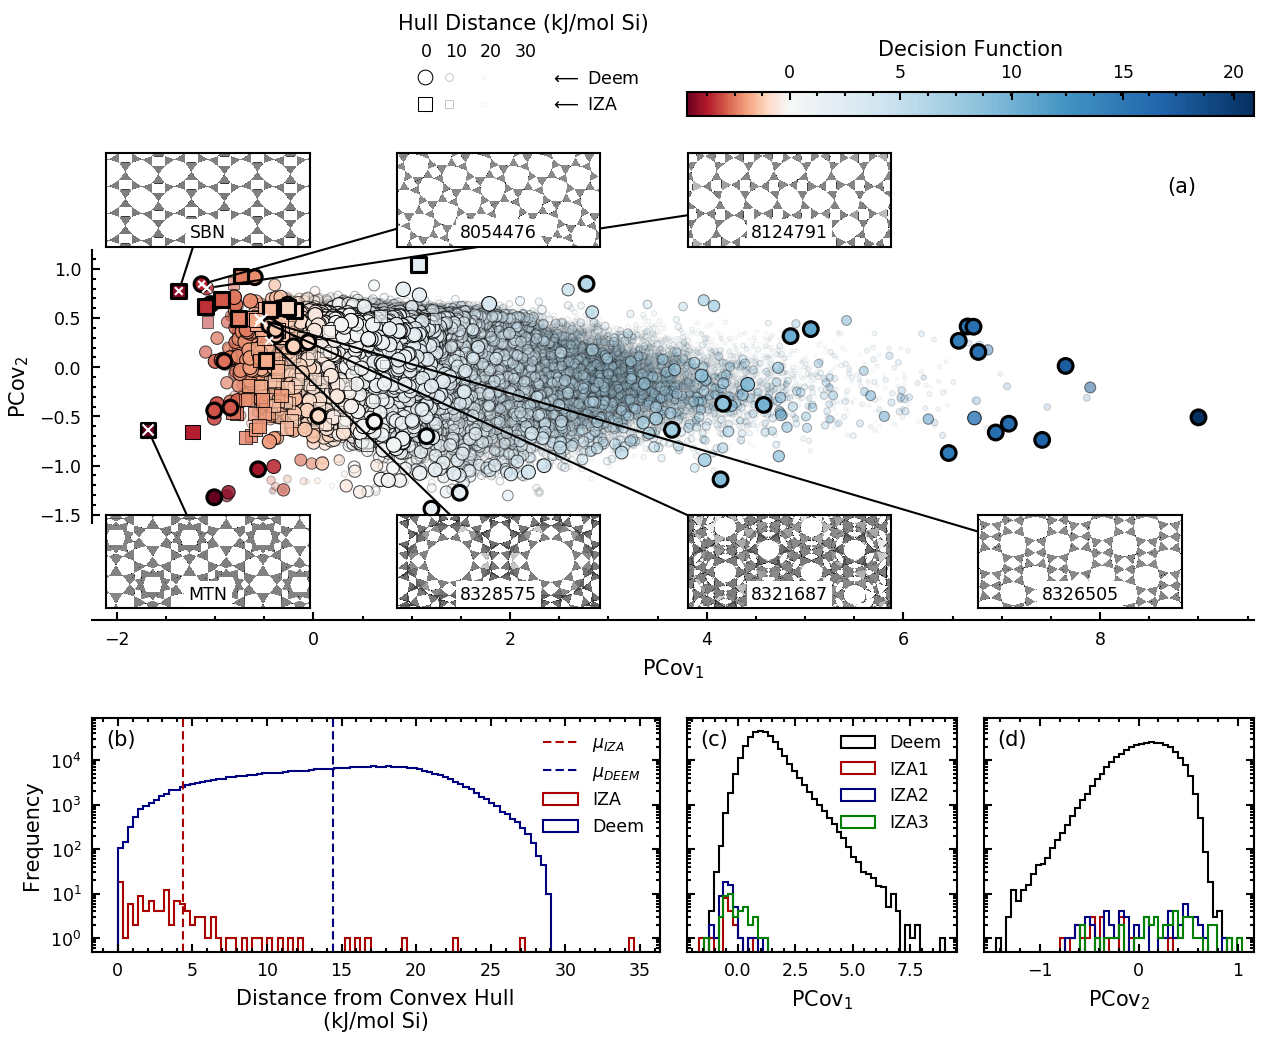

In [22]:
T_ratio = (np.amax(T[:, 0]) - np.amin(T[:, 0])) / (np.amax(T[:, 1]) - np.amin(T[:, 1]))
# width_ratios = (1.0, 0.25, 1.0, 1.0, 1.0)
width_ratios = (1.0, 1.0, 1.0, 1.0)
height_ratios = (0.05, 1.0, 0.05, 0.5)
fig_width = 10.0
fig_height = 2 * sum(height_ratios) * (fig_width / T_ratio)

fig = plt.figure(figsize=(fig_width, fig_height))
gs = fig.add_gridspec(
#     nrows=4, ncols=5,
    nrows=4, ncols=4,
    width_ratios=width_ratios, height_ratios=height_ratios,
    wspace=0.10, hspace=0.20
)

# GCH
axs = fig.add_subplot(gs[1, :])
axs.set_aspect(aspect='equal', anchor='W', adjustable='datalim')
# hull_axs = fig.add_subplot(gs[-1, 2])
hull_axs = fig.add_subplot(gs[-1, 0:2])
caxs = fig.add_subplot(gs[0, 2:4])
# zoom_axs = fig.add_subplot(gs[-1, 0])
# zoom_axs.set_aspect(aspect='equal')
pcovr_axes = [fig.add_subplot(gs[-1, i]) for i in range(-2, 0)]
grouper = hull_axs.get_shared_y_axes()
for ax in pcovr_axes:
    grouper.join(ax, hull_axs)
    ax.tick_params(labelleft=False)

T_iza = np.delete(T[0:n_iza], iza_vertices, axis=0)
de_iza = np.delete(de[0:n_iza], iza_vertices)
df_iza = np.delete(dfs[0:n_iza], iza_vertices)
s_iza = np.delete(sizes[0:n_iza], iza_vertices)
colors_iza = np.delete(colors[0:n_iza], iza_vertices, axis=0)
ecolors_iza = np.delete(ecolors[0:n_iza], iza_vertices, axis=0)
po_iza = np.flip(np.argsort(de_iza))

T_deem = np.delete(T[n_iza:], deem_vertices - n_iza, axis=0)
de_deem = np.delete(de[n_iza:], deem_vertices - n_iza)
df_deem = np.delete(dfs[n_iza:], deem_vertices - n_iza)
s_deem = np.delete(sizes[n_iza:], deem_vertices - n_iza)
colors_deem = np.delete(colors[n_iza:], deem_vertices - n_iza, axis=0)
ecolors_deem = np.delete(ecolors[n_iza:], deem_vertices - n_iza, axis=0)
po_deem = np.flip(np.argsort(de_deem))

T_iza_vertices = T[iza_vertices]
de_iza_vertices = de[iza_vertices]
df_iza_vertices = dfs[iza_vertices]
s_iza_vertices = sizes[iza_vertices]
colors_iza_vertices = colors[iza_vertices]
ecolors_iza_vertices = ecolors[iza_vertices]

T_deem_vertices = T[deem_vertices]
de_deem_vertices = de[deem_vertices]
df_deem_vertices = dfs[deem_vertices]
s_deem_vertices = sizes[deem_vertices]
colors_deem_vertices = colors[deem_vertices]
ecolors_deem_vertices = ecolors[deem_vertices]

# Deem
deem_pts = axs.scatter(
    T_deem[po_deem, 0], T_deem[po_deem, 1],
    c=colors_deem[po_deem],
    marker='o', edgecolor=ecolors_deem[po_deem], linewidth=0.5, s=s_deem[po_deem],
    rasterized=True
)
# IZA
iza_pts = axs.scatter(
    T_iza[po_iza, 0], T_iza[po_iza, 1],
    c=colors_iza[po_iza],
    marker='s', edgecolor=ecolors_iza[po_iza], linewidth=0.5, s=s_iza[po_iza],
    rasterized=True
)

# Deem vertices
axs.scatter(
    T_deem_vertices[:, 0], T_deem_vertices[:, 1],
    c=colors_deem_vertices,
    marker='o', edgecolor=ecolors_deem_vertices, linewidth=1.5, s=s_deem_vertices,
    zorder=3,
    rasterized=True
)

# IZA vertices
axs.scatter(
    T_iza_vertices[:, 0], T_iza_vertices[:, 1],
    c=colors_iza_vertices,
    marker='s', edgecolor=ecolors_iza_vertices, linewidth=1.5, s=s_iza_vertices,
    zorder=3,
    linewidths=2,
    rasterized=True
)

# Deem select
axs.scatter(
    T[deem_select_idxs, 0], T[deem_select_idxs, 1],
    c='w',
    marker='x', linewidth=1, s=s_deem[deem_select_idxs],
    zorder=3,
    rasterized=True
)

# IZA select
axs.scatter(
    T[iza_select_idxs, 0], T[iza_select_idxs, 1],
    c='w',
    marker='x', linewidth=1, s=s_iza[iza_select_idxs],
    zorder=3,
    rasterized=True
)

cb = fig.colorbar(
    color_map, cax=caxs, 
    label='Decision Function', 
    orientation='horizontal', 
    extend=extend_key,
    ticklocation='top'
)

axs.set_xlabel(r'PCov$_1$')
axs.set_ylabel(r'PCov$_2$')

xcenter = 0.0
xlim = axs.get_xlim()
xticks = axs.get_xticks()
xticks_minor = axs.get_xticks(minor=True)
xticklabels = axs.get_xticklabels()

ycenter = 0.0
ylim = axs.get_ylim()
yticks = axs.get_yticks()
yticks_minor = axs.get_yticks(minor=True)
yticklabels = axs.get_yticklabels()

axs.set_xticks(xticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_xticks(xticks_minor, minor=True)

axs.set_yticks(yticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_yticks(yticks_minor, minor=True)

axs.spines['left'].set_bounds(*ylim)
axs.spines['bottom'].set_bounds(*xlim)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.tick_params(which='both', axis='both', top=False, right=False)

legend_distances = np.linspace(int(np.amin(de)), 10*int(np.amax(de) // 10), 4, dtype=int)
legend_sizes = scale_points(legend_distances, size_min, size_max, inverted=True, log=True, base=base, min_limit=0.0)
legend_alphas = scale_points(legend_distances, alpha_min, alpha_max, inverted=True, log=True, base=base, min_limit=0.0)

legend_patches = []
for legend_distance, legend_size, legend_alpha in zip(legend_distances, legend_sizes, legend_alphas):
    legend_patches.append(Line2D(
        [0], [0],
        linewidth=0.0,
        markersize=0.0,
        label=legend_distance
    ))
    for marker in ('o', 's'):
        legend_patches.append(Line2D(
            [0], [0],
            linewidth=0.0,
            marker=marker, markerfacecolor='w', 
            markeredgecolor=color_list[0], markeredgewidth=0.5,
            alpha=legend_alpha, markersize=np.sqrt(legend_size),
        ))

for label in ('', r'$\longleftarrow$ Deem', r'$\longleftarrow$ IZA'):
    legend_patches.append(Line2D([0], [0], linewidth=0.0, markersize=0.0, label=label))
    
legend = axs.legend(
    handles=legend_patches, 
    title='Hull Distance (kJ/mol Si)',
    loc='lower left', bbox_to_anchor=(0.25, 1.05),
    ncol=len(legend_patches) // 3,
    handletextpad=-1.25,
    columnspacing=0.0
)

# Zoom near zero
# zoom_x = [-1.0, 0.5]
# zoom_y = [-0.75, 0.75]
# zoom_axs.set_xlim(zoom_x)
# zoom_axs.set_ylim(zoom_y)
# patch, connector_lines = axs.indicate_inset_zoom(zoom_axs)
# zoom_axs.set_xlabel(r'PCov$_1$')
# zoom_axs.set_ylabel(r'PCov$_2$')

# # TODO: assign alphas
# for canton, m in zip(np.unique(iza_cantons), ['^', '<', '>']):
#     po_idxs = np.nonzero(iza_cantons[po_iza] == canton)[0]
#     iza_zoom_pts = zoom_axs.scatter(
#         T_iza[po_iza[po_idxs], 0], T_iza[po_iza[po_idxs], 1],
#         c=Si_fraction_iza[po_iza[po_idxs]],
#         cmap='inferno',
#         marker=m, edgecolor='k', linewidth=0.5, s=s_iza[po_iza[po_idxs]],
#         rasterized=True,
#         label=f'IZA{canton}'
#     )
    
# zoom_axs.legend(bbox_to_anchor=(-0.1, 1.0), loc='lower left', ncol=3, columnspacing=0.1, handletextpad=0.0)

# cb_composition = fig.colorbar(
#     color_map_composition, ax=zoom_axs, 
#     label='Si Fraction', 
#     orientation='vertical', 
# )

#for legend_text in legend.get_texts()[1:-1:2]:
#    legend_text.set_visible(False)

deem_inset_positions = np.array([
    [0.75, 0.025],
    [0.25, 0.8],
    [0.50, 0.8],
    [0.50, 0.025],
    [0.25, 0.025],
])
iza_inset_positions = np.array([
    [0.0, 0.025],
    [0.0, 0.8]
])

inset_size = [0.2, 0.2]

for cdx, (select_frames, color, t, inset_positions) in enumerate(zip(
    (frames_iza_select, frames_deem_select),
    (color_list[0], color_list[0]),
    (T[iza_select_idxs, 0:2], T[deem_select_idxs, 0:2]),
    (iza_inset_positions, deem_inset_positions)
)):
    for vdx, (tt, inset_position, frame) in enumerate(zip(t, inset_positions, select_frames)):
        axs_inset = axs.inset_axes([*inset_position, *inset_size])
        #plot_atoms(frame, axs_inset)
        axs_inset_center = np.array(inset_position) + np.array(inset_size) / 2
        
        axs.annotate(
            '',
            xy=tt,
            xytext=axs_inset_center,
            xycoords=axs.transData,
            textcoords=axs.transAxes,
            arrowprops=dict(arrowstyle='-', color=color, shrinkB=4, zorder=4),
        )
        
        axs_inset.tick_params(
            which='both', axis='both', 
            left=False, bottom=False, right=False, top=False,
            labelleft=False, labelbottom=False, labelright=False, labeltop=False
        )
        
        if cdx == 0:
            frame_id = frame.info['code']
        else:
            frame_id = frame.info['Filename'].split('.')[0]

        img_file = f"{vertex_structure_dir}/{frame_id}.png"
            
        if os.path.exists(img_file):
            img = mplimg.imread(img_file)
            min_img_dim = None #np.amin(img.shape[0:2])
            axs_inset.imshow(img[0:min_img_dim, 0:min_img_dim])
        
        frame_label = axs_inset.text(
            0.50, 0.055,
            frame_id,
            horizontalalignment='center', verticalalignment='bottom',
            bbox=dict(facecolor='w', pad=2.0, linewidth=0.0),
            fontsize='small',
            transform=axs_inset.transAxes,
        )

axs.text(
    0.95, 0.95, '(a)', 
    horizontalalignment='right', verticalalignment='top', transform=axs.transAxes
)

# PCovR HISTOGRAMS
histogram_max = np.amax(T, axis=0)
histogram_min = np.amin(T, axis=0)
pcovr_histogram_parameters = dict(bins=50, density=False, log=True, histtype='step')

for pc, pcovr_axs in enumerate(pcovr_axes):
    histogram_range = (histogram_min[pc], histogram_max[pc])

    pcovr_axs.hist(
        T[n_iza:, pc], 
        range=histogram_range, 
        **pcovr_histogram_parameters, label='Deem'
    )
    
    for i in range(1, np.amax(iza_cantons)+1):
        canton_idxs = np.nonzero(iza_cantons == i)[0]
        
        pcovr_axs.hist(
            T[0:n_iza, pc][canton_idxs], 
            range=histogram_range, 
            **pcovr_histogram_parameters, label=f'IZA{i}'
        )
            
    if pc == 0:
#         pcovr_axs.set_ylabel('Frequency')
        pcovr_axs.text(
            0.05, 0.95, '(c)', 
            horizontalalignment='left', verticalalignment='top', transform=pcovr_axs.transAxes
        )
    else:
        pcovr_axs.text(
            0.05, 0.95, '(d)', 
            horizontalalignment='left', verticalalignment='top', transform=pcovr_axs.transAxes
        )
        
    pcovr_axs.set_xlabel(fr'PCov$_{{{pc+1}}}$')
    pcovr_axs.set_ylim((0.5, pcovr_axs.get_ylim()[1]))

pcovr_axes[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# HULL HISTOGRAM
hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    density=False, bins=100, log=True,
)

hull_axs.hist(
    de[0:n_iza], **hull_histogram_parameters, 
    color=color_list[1], histtype='step', label='IZA'
)
hull_axs.axvline(
    np.mean(de[0:n_iza]), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

hull_axs.hist(
    de[n_iza:], 
    **hull_histogram_parameters, 
    color=color_list[2], histtype='step', label='Deem'
)
hull_axs.axvline(
    np.mean(de[n_iza:]), 
    color=color_list[2], linestyle='--', label=r'$\mu_{DEEM}$'
)

hull_axs.set_ylabel('Frequency')
hull_axs.set_xlabel('Distance from Convex Hull\n(kJ/mol Si)')
hull_axs.set_ylim((0.5, hull_axs.get_ylim()[1]))

hull_axs.legend()

hull_axs.text(
    0.025, 0.95, '(b)', 
    horizontalalignment='left', verticalalignment='top', transform=hull_axs.transAxes
)

fig.savefig(f'../../Results/{cutoff}/gch_{cutoff}_{spectrum}_{group_name}{mixing}.pdf', bbox_inches='tight')

plt.show()

# Correlations of components with composition

In [ ]:
for i in range(0, T.shape[1]):
    s = plt.scatter(T[0:n_iza, i], Si_fraction_iza, c=iza_cantons, cmap='tab10')
    plt.legend(*s.legend_elements(), frameon=True, framealpha=1)
    rho, _ = pearsonr(T[0:n_iza, i], Si_fraction_iza)
    plt.text(
        0.25, 0.25,
        fr'$\rho = {rho:.3f}$',
        horizontalalignment='left',
        verticalalignment='center',
        transform=s.axes.transAxes
    )
    plt.xlabel(f'PCov{i+1}')
    plt.ylabel('Si fraction')
    plt.show()

In [ ]:
# Correlation coefficients for all (2-Class)
for i in range(0, T.shape[1]):
    s = plt.scatter(T[:, i], dfs_2, c=cantons_2, cmap='tab10')
    plt.legend(*s.legend_elements(), frameon=True, framealpha=1)
    rho, _ = pearsonr(T[:, i], dfs_2)
    plt.text(
        0.95, 0.05,
        fr'$\rho = {rho:.3f}$',
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=s.axes.transAxes
    )
    plt.xlabel(f'PCov{i+1}')
    plt.ylabel('2-Class Decision Function')
    plt.show()

In [ ]:
# Correlation coefficients for all (4-Class)
for i in range(0, T.shape[1]):
    for j in range(0, dfs_4.shape[1]):
        s = plt.scatter(T[:, i], dfs_4[:, j], c=cantons_4, cmap='tab10')
        plt.legend(*s.legend_elements(), frameon=True, framealpha=1)
        rho, _ = pearsonr(T[:, i], dfs_4[:, j])
        plt.text(
            0.95, 0.05,
            fr'$\rho = {rho:.3f}$',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=s.axes.transAxes
        )
        plt.xlabel(f'PCov{i+1}')
        plt.ylabel(f'4-Class Decision Function {j+1} vs. Rest')
        plt.show()

In [ ]:
# Correlation coefficients for IZA only
for i in range(0, T.shape[1]):
    for j in range(0, dfs_4.shape[1]):
        s = plt.scatter(T[0:n_iza, i], dfs_4[0:n_iza, j], c=iza_cantons, cmap='tab10')
        plt.legend(*s.legend_elements(), frameon=True, framealpha=1)
        rho, _ = pearsonr(T[0:n_iza, i], dfs_4[0:n_iza, j])
        plt.text(
            0.95, 0.05,
            fr'$\rho = {rho:.3f}$',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=s.axes.transAxes
        )
        plt.xlabel(f'PCov{i+1}')
        plt.ylabel(f'4-class Decision function {j+1} vs. Rest')
        plt.show()

# Hull stats

In [ ]:
print(np.argmax(de), np.amax(de))

In [ ]:
iza_de = np.argsort(de)
iza_de = iza_de[iza_de < n_iza]
for dist, code, canton in zip(
    de[iza_de], 
    iza_codes[iza_de], 
    iza_cantons[iza_de]
):
    print(f'{code}\t{canton}\t{dist}')

In [ ]:
canton_1_idxs = np.nonzero(iza_cantons == 1)[0]
iza_de = np.argsort(de[canton_1_idxs])
for dist, code, canton in zip(
    de[canton_1_idxs][iza_de], iza_codes[canton_1_idxs][iza_de], iza_cantons[canton_1_idxs][iza_de]
):
    print(f'{code}\t{canton}\t{dist}')

In [ ]:
de_limit = de[canton_1_idxs][iza_de][-1]
print(de_limit)

## SVM-based candidates

In [ ]:
def k_nearest_neighbors(A, B, y, k=1):
    """
        Computes the property y' for dataset A
        based on the average of properties y of 
        the k closest instances of dataset B 
        (Euclidean distance)
        
        ---Arguments---
        A: dataset with unknown properties
        B: "reference" dataset with known properties
        y: known properties of dataset B
        k: number of nearest neighbors
        
        ---Returns---
        yy: k-nearest-neighbor properties for dataset A
    """
    
    if A.ndim == 1:
        A = np.reshape(A, (-1, 1))
    if B.ndim == 1:
        B = np.reshape(B, (1, -1))
        
    D = pairwise_distances(A, B, metric='euclidean')
    idxs = np.argsort(D, axis=1)[:, 0:k]
    yy = np.mean(y[idxs], axis=1)
    return yy

In [ ]:
most_iza_deem_idxs = np.argsort(deem_330k_dfs_2)
most_iza_iza_idxs = np.argsort(iza_dfs_2)

In [ ]:
n_select = 5

In [ ]:
# Most IZA-like Deem
most_iza_idxs = most_iza_deem_idxs[0:n_select]
most_iza_soap_idxs = deem_codes[most_iza_idxs] - 8000001
most_iza_sort_idxs = np.argsort(most_iza_soap_idxs)
most_iza_unsort_idxs = np.argsort(most_iza_sort_idxs)

print(deem_codes[most_iza_idxs])
print(deem_330k_dfs_2[most_iza_idxs])
print(Si_fraction_deem[most_iza_idxs])

# Load SOAPs
deem_soaps = utils.load_hdf5(
    f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=most_iza_soap_idxs[most_iza_sort_idxs]
)[most_iza_unsort_idxs]

iza_soaps = utils.load_hdf5(
    f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=iza_test_idxs[iza_sort_test_idxs]
)[iza_unsort_test_idxs]

predicted_Si_fraction = k_nearest_neighbors(deem_soaps, iza_soaps, Si_fraction_iza, k=1)
print(predicted_Si_fraction.squeeze())

In [ ]:
# Most Deem-like Deem
most_deem_idxs = most_iza_deem_idxs[-n_select:]
print(deem_codes[most_deem_idxs])
print(deem_330k_dfs_2[most_deem_idxs])
print(Si_fraction_deem[most_deem_idxs])

In [ ]:
# Most IZA-like IZA
most_iza_idxs = most_iza_iza_idxs[0:n_select]
print(iza_codes[most_iza_idxs])
print(iza_dfs_2[most_iza_idxs])
print(Si_fraction_iza[most_iza_idxs])

In [ ]:
# Most Deem-like IZA
most_deem_idxs = most_iza_iza_idxs[-n_select:]
print(iza_codes[most_deem_idxs])
print(iza_dfs_2[most_deem_idxs])
print(Si_fraction_iza[most_deem_idxs])

## GCH-based candidates

In [ ]:
print(gch_vertices)

In [ ]:
# Vertex structures
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)
print(df_iza_vertices)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)
print(df_deem_vertices)

In [ ]:
gch_vertices_de = np.nonzero(de <= de_limit)[0]
iza_vertices_de = gch_vertices_de[gch_vertices_de < n_iza]
deem_vertices_de = gch_vertices_de[gch_vertices_de >= n_iza]

In [ ]:
# Structures within de_limit of hull
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

In [ ]:
# Searching top x% of structures
search_fraction = 0.05
n_search_iza = int(search_fraction * n_iza)
n_search_deem = int(search_fraction * n_deem)

# IZA-like DEEM
id_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[0:n_search_deem]]
)
n_id = len(id_intersect)
print('=== IZA-like Deem ===')
print(n_id / n_search_deem)
print(id_intersect)

# IZA-like IZA
ii_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[0:n_search_iza]]
)
n_ii = len(ii_intersect)
print('=== IZA-like IZA ===')
print(n_ii / n_search_iza)
print(ii_intersect)

# DEEM-like IZA
di_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[-n_search_iza:]]
)
n_di = len(di_intersect)
print('=== Deem-like IZA ===')
print(n_di / n_search_iza)
print(di_intersect)

# DEEM-like DEEM
dd_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[-n_search_deem:]]
)
n_dd = len(dd_intersect)
print('=== Deem-like Deem ===')
print(n_dd / n_search_deem)
print(dd_intersect)

print(f'Total Deem: {n_id + n_dd}')
print(f'Total IZA: {n_di + n_ii}')

In [ ]:
iza_df = np.argsort(iza_dfs_2[canton_1_idxs])
for dist, code, canton in zip(
    iza_dfs_2[canton_1_idxs][iza_df], 
    iza_codes[canton_1_idxs][iza_df], 
    iza_cantons[canton_1_idxs][iza_df]
):
    print(f'{code[-3:]}\t{canton}\t{dist}')

In [ ]:
df_limit = np.amax(iza_dfs_2[canton_1_idxs])
print(df_limit)

In [ ]:
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]
iza_vertices_df = gch_vertices_df[gch_vertices_df < n_iza]
deem_vertices_df = gch_vertices_df[gch_vertices_df >= n_iza]

In [ ]:
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [ ]:
# Structures within df_limit (most Deem-like IZA1)
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

In [ ]:
# Candidates within the energy envelope of the hull and decision function values defined by IZA1
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

In [ ]:
de_limit = 1.0E-2
df_limit = 0.0

gch_vertices_de = np.nonzero(de < de_limit)[0]
iza_vertices_de = gch_vertices_de[gch_vertices_de < n_iza]
deem_vertices_de = gch_vertices_de[gch_vertices_de >= n_iza]

gch_vertices_df = np.nonzero(dfs < df_limit)[0]
iza_vertices_df = gch_vertices_df[gch_vertices_df < n_iza]
deem_vertices_df = gch_vertices_df[gch_vertices_df >= n_iza]

gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [ ]:
# Filter within de_limit of the hull and less than df_limit in decision function
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

In [ ]:
# Load SOAPs
deem_soaps = utils.load_hdf5(
    f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=deem_test_idxs[deem_vertices_df_de - n_iza]
)

iza_soaps = utils.load_hdf5(
    f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=iza_test_idxs[iza_sort_test_idxs]
)[iza_unsort_test_idxs]

In [ ]:
# Find identical Deem frameworks
D_deem = pairwise_distances(deem_soaps, metric='euclidean')

In [ ]:
plt.hist(np.log10(D_deem[np.triu_indices(D_deem.shape[0], k=1)]), histtype='step', bins=100, log=False)
plt.show()

In [ ]:
# Find closest IZA frameworks to all Deem frameworks
D = pairwise_distances(deem_soaps, iza_soaps, metric='euclidean')
D_min_idxs = np.argmin(D, axis=1)
D_min = np.amin(D, axis=1)

In [ ]:
# Print some extra info for the above Deem frameworks
# in a format we can copy and paste into a LaTeX table
class_key = {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
select_deem_codes = deem_codes[deem_vertices_df_de - n_iza]
select_deem_de = de[deem_vertices_df_de]
select_deem_dfs_2 = dfs_2[deem_vertices_df_de]
select_deem_cantons_4 = predicted_deem_cantons_4[deem_vertices_df_de - n_iza]

# Top 50 candidates close to hull
n_top = 50
hull_sort_idxs = np.argsort(select_deem_de)[0:n_top]

# Sort
df_sort_idxs = np.argsort(select_deem_dfs_2[hull_sort_idxs])


for idx, (deem_code, hull_distance, dec_func, canton, iza_code, iza_canton, iza_dist) in enumerate(zip(
    select_deem_codes[hull_sort_idxs][df_sort_idxs],
    select_deem_de[hull_sort_idxs][df_sort_idxs],
    select_deem_dfs_2[hull_sort_idxs][df_sort_idxs],
    [class_key[canton] for canton in select_deem_cantons_4[hull_sort_idxs][df_sort_idxs]],
    iza_codes[D_min_idxs][hull_sort_idxs][df_sort_idxs],
    iza_cantons[D_min_idxs][hull_sort_idxs][df_sort_idxs],
    D_min[hull_sort_idxs][df_sort_idxs]
)):
    print(
        f'({idx+1:2d}) & '
        f'{deem_code} & '
        f'\\num{{{hull_distance:0.2e}}} & '
        f'{dec_func:0.2f} & '
        f'{canton} & '
        f'{iza_code} (IZA{iza_canton}) & '
        f'\\num{{{iza_dist:0.2e}}} \\\\'
    )

In [ ]:
plt.hist(Si_fraction[0:n_iza], bins=20)
plt.show()

In [ ]:
plt.scatter(de[n_iza:], dfs_2[n_iza:])
plt.scatter(de[0:n_iza], dfs_2[0:n_iza], c=Si_fraction[0:n_iza], cmap='viridis')
plt.xlabel('E')
plt.ylabel('df')
plt.xlim([-0.2, 2])
plt.ylim([-5, 0])
plt.colorbar()
plt.show()

# Build a chemiscope

In [ ]:
np.count_nonzero(np.logical_and(de < 5, dfs < 0))

In [ ]:
# Construct a chemiscope on a broad subset of the most promising structures
chemiscope_de_limit = 5.0
chemiscope_df_limit = 0.0
chemiscope_deem_idxs = np.intersect1d(
    np.nonzero(de < chemiscope_de_limit)[0],
    np.nonzero(dfs < chemiscope_df_limit)[0]
)
chemiscope_deem_idxs = chemiscope_deem_idxs[chemiscope_deem_idxs >= n_iza]
chemiscope_deem_frames = [deepcopy(frames[i]) for i in chemiscope_deem_idxs]

chemiscope_iza_frames = deepcopy(frames[0:n_iza])
chemiscope_iza_idxs = np.arange(0, n_iza)

chemiscope_frames = chemiscope_iza_frames + chemiscope_deem_frames
chemiscope_idxs = np.concatenate((chemiscope_iza_idxs, chemiscope_deem_idxs))

# Strip the properties from the frames, we will set them manually
for frame in chemiscope_frames:
    frame.info = {}

In [ ]:
def int_class_to_str(class_ints, n_classes=2):
    conversion_dict = {
        2: {1: 'IZA', 2:'Deem'},
        4: {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
    }
    return np.array([conversion_dict[n_classes][c] for c in class_ints])

In [ ]:
# Also 2 and 4 class decision function values
chemiscope_properties = dict(
    codes=dict(target='structure', values=codes[chemiscope_idxs]),
    projection=dict(target='structure', values=T[chemiscope_idxs, 0:2]),
    energies=dict(target='structure', values=energies[chemiscope_idxs]),
    volumes=dict(target='structure', values=volumes[chemiscope_idxs]),
    vertex=dict(target='structure', values=vertex_indicators[chemiscope_idxs]),
#     vertex_probability=dict(target='structure', values=vprobprune[prune_iter][chemiscope_idxs]),
    true_class_2=dict(target='structure', values=int_class_to_str(cantons_2[chemiscope_idxs])),
    true_class_4=dict(target='structure', values=int_class_to_str(cantons_4[chemiscope_idxs], n_classes=4)),
    predicted_class_2=dict(target='structure', values=int_class_to_str(predicted_cantons_2[chemiscope_idxs])),
    predicted_class_4=dict(target='structure', values=int_class_to_str(predicted_cantons_4[chemiscope_idxs], n_classes=4)),
    decision_function_2=dict(target='structure', values=dfs_2[chemiscope_idxs]),
    decision_function_4=dict(target='structure', values=dfs_4[chemiscope_idxs]),
    hull_distance=dict(target='structure', values=d[chemiscope_idxs]),
    hull_distance_energy=dict(target='structure', values=de[chemiscope_idxs]),
    Si_fraction=dict(target='structure', values=Si_fraction[chemiscope_idxs])
)

In [ ]:
chemiscope.write_input(
    f'{gch_dir}/svm-pcovr-gch_chemiscope{mixing}.json.gz', 
    chemiscope_frames, 
    meta=dict(name='SVM-PCovR-GCH'),
    properties=chemiscope_properties,
    cutoff=None
)

## Plot the "chemiscope"

In [ ]:
with gzip.GzipFile(f'{gch_dir}/svm-pcovr-gch_chemiscope{mixing}.json.gz', 'r') as f:
    data = json.load(f)

In [ ]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['energies']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class_2']['values'])
predicted_class = np.array(data['properties']['predicted_class_2']['values'])
vertex = np.array(data['properties']['vertex']['values'])
# vertex_probability = np.array(data['properties']['vertex_probability']['values'])

In [ ]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [ ]:
classes = sorted(list(set(true_class)))

In [ ]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    v = vertex[true_class == t]
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(
        x=X, 
        y=Y, 
        z=Z, 
        mode='markers',
        marker=dict(
            color=HDE,
            coloraxis='coloraxis',
            line_width=1,
            size=3,
            symbol=s,
        ),
        name=t,
        hovertemplate="%{marker.color}"
    ))
    fig.add_trace(go.Scatter3d(
        x=X[np.nonzero(v)[0]], 
        y=Y[np.nonzero(v)[0]], 
        z=Z[np.nonzero(v)[0]], 
        mode='markers',
        marker=dict(
            color=HDE[np.nonzero(v)[0]],
            coloraxis='coloraxis',
            line_width=1,
            size=8,
            symbol=s,
        ),
        name=t,
        hovertemplate="%{marker.color}"
    ))

fig.add_trace(go.Mesh3d(
    alphahull=-1,
    x=T1[np.nonzero(vertex)[0]], 
    y=T2[np.nonzero(vertex)[0]], 
    z=E[np.nonzero(vertex)[0]],
    color='skyblue',
    opacity=0.25,
    hoverinfo='skip'    
))

fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis_title='T<sub>1</sub>',
        yaxis_title='T<sub>2</sub>',
        zaxis_title='Energy per Si<br>(kJ/mol Si)'
    ),
    legend=dict(
        x=0.0, 
        y=1.0,
        xanchor='left', 
        yanchor='top',
        itemsizing='constant'
    ),
    coloraxis=dict(
        colorscale='RdBu',
        colorbar=dict(title='Hull Distance<br>(kJ/mol)'),
        cmid=0
    ),
    autosize=False,
    width=600, 
    height=600
)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')